# Увеличение выручки интернет-магазина
Вместе с отделом маркетинга крупного интернет-магазина был подготовлен список гипотез для увеличения выручки. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Ход исследования:**

Данные мы получим из файлов:
 -   hypothesis.csv - список гипотез (данные для первой части)
 -   orders.csv - информация о заказах по итогам A/B-теста (данные для второй части)
 -   visitors.csv - информация о пользователях

О качестве данных ничего не известно. Поэтому перед проведением исследовательского анализа нам понадобится сделать их обзор. Мы проверим данные на ошибки и затем на этапе предобработки исправим критичные ошибки.

Таким образом, исследование пройдет в несколько этапов:

1. Изучение данных.
2. Предобработка данных.
3. Исследовательский анализ данных.

## Обзор данных

### Получение общей информации о данных

Загрузим данные о гипотезах, заказах и пользователях. Оптимизируем их для анализа. Убедимся, что тип данных в каждой колонке — правильный. Путь к файлам:

 *   hypothesis.csv
 *   orders.csv 
 *   visitors.csv

In [1]:
import pandas as pd
import numpy as np
import math as mth
import scipy.stats as stats
import datetime as dt
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

register_matplotlib_converters()

In [2]:
# функция для первичного анализа датасета и корректировки названия столбцов
def primary_analysis (data):
    display(data.head(5))
    display(data.info())
    data.columns = [x.lower().replace(' ', '_') for x in data.columns]
    print("Количество явных дубликатов:", data.duplicated().sum())

hypothesis, orders, visitors = (
    pd.read_csv('hypothesis.csv'),  # список гипотезы
    pd.read_csv('orders.csv'),      # информация о заказах по итогу A/B теста
    pd.read_csv('visitors.csv')     # информация о пользователях по итогу A/B теста
)

primary_analysis(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

Количество явных дубликатов: 0


Описание столбцов '/datasets/hypothesis.csv' согласно документации:
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [3]:
primary_analysis(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Количество явных дубликатов: 0


Описание столбцов '/datasets/orders.csv' согласно документации:
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

In [4]:
primary_analysis(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Количество явных дубликатов: 0


Описание столбцов '/datasets/visitors.csv' согласно документации:
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

В датасетах 'orders' и 'visitors' тип данных столбца 'date' не соответствует значению. Кроме того, не будет лишним откорректировать название столбцов.

### Предобработка данных

In [5]:
# преобразуем данные о времени
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

# откорректируем название столбцов в orders
orders.columns = orders.columns.str.replace("id", "_id")

orders.info()
display(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

На следующем шаге изучим более подробно данные датасета:    

In [6]:
#проверка количества групп в АВ-тесте
print("Количество групп в АВ-тесте: датасет 'orders' -", orders['group'].nunique(), "; датасет 'visitors' -", visitors['group'].nunique())

Количество групп в АВ-тесте: датасет 'orders' - 2 ; датасет 'visitors' - 2


In [7]:
#проверка даты начала и окончания теста
print("Дата начала АВ-теста: датасет 'orders' -", orders['date'].dt.strftime('%m/%d/%Y').min(), "; датасет 'visitors' -", visitors['date'].dt.strftime('%m/%d/%Y').min())
print("Дата начала АВ-теста: датасет 'orders' -", orders['date'].dt.strftime('%m/%d/%Y').max(), "; датасет 'visitors' -", visitors['date'].dt.strftime('%m/%d/%Y').max())

Дата начала АВ-теста: датасет 'orders' - 08/01/2019 ; датасет 'visitors' - 08/01/2019
Дата начала АВ-теста: датасет 'orders' - 08/31/2019 ; датасет 'visitors' - 08/31/2019


In [8]:
# количество пользователей для каждой группе в датасете orders
print("Количество уникальных пользователей в группе А:", orders[orders['group'] == 'A']['visitor_id'].nunique())
print("Количество уникальных пользователей в группе B:", orders[orders['group'] == 'B']['visitor_id'].nunique())

Количество уникальных пользователей в группе А: 503
Количество уникальных пользователей в группе B: 586


In [9]:
# Проверим, не попадают ли какие-то пользователи в обе группы - по таблице с заказами
print("Количество вхождений, попадающих в обе группы теста:", orders[orders['group'] == 'A']['visitor_id'].isin(orders[orders['group'] == 'B']['visitor_id']).sum(axis=0))

Количество вхождений, попадающих в обе группы теста: 89


Проверка показала, что 89 пользователей попадают в обе группы, в А и В, при этом количество пользователей в группе В на 83 больше, чем в группе А. 

**Вывод:** данные готовы для исследователького анализа.

## Исследовательский анализ данных
### Приоритизация гипотез

Проанализируем датасет с гипотезами:

In [10]:
pd.options.display.max_colwidth = 120
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета:

In [11]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
pd.options.display.max_colwidth = 120
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


На следующем шаге применим фреймворк RICE для приоритизации гипотез и также отсортируем их по убыванию приоритета:

In [12]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
pd.options.display.max_colwidth = 120
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Вывод**

При применении фреймворка RICE вместо ICE приоритизация гипотез изменилась: гипотезы 7, 2 и 0 стали наиболее приоритетными (по убыванию) из-за параметра Reach, который показывает, как много пользователей каждая гипотеза затронет. Гипотеза 7 охватывает максимальную аудиторию пользователей, поскольку для нее параметр Reach равен 10. 
Аудитория для гипотезы 2 - меньше, ее параметр Reach равен 8. 
По этой же причине гипотеза 0 со значением Reach, равным 3, переместилась с первого на третье место.

## Анализ A/B-теста

### График кумулятивной выручки по группам 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


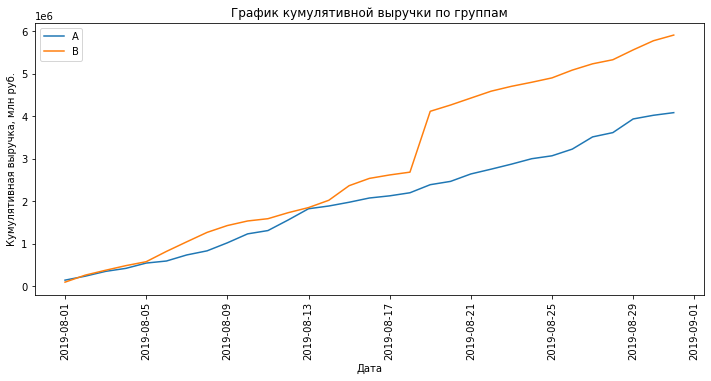

In [13]:
# массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

# агрегированные кумулятивные по дням данные о заказах:
ordersAggregated = ( 
    datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
    .agg(
        {'date' : 'max',
         'group' : 'max', 
         'transaction_id' : 'nunique', 
         'visitor_id' : 'nunique', 
         'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group']))

# агрегированные кумулятивные по дням данные о посетителях:
visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                      .agg(
                          {'date' : 'max', 
                           'group' : 'max', 
                           'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

# объединяем кумулятивные данные в одной таблице и корректируем названия столбцов
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulativeData.head(5)) 

# Построим графики кумулятивной выручки по дням и группам A/B-тестирования:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']] 

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation ='vertical')
plt.legend()
plt.ylabel('Кумулятивная выручка, млн руб.')
plt.xlabel('Дата')
plt.title('График кумулятивной выручки по группам');

**Вывод:** 

Выручка почти равномерно увеличивается в течение всего теста. График выручки для группы В в одной точке графика резко растет. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

### График кумулятивного среднего чека по группам

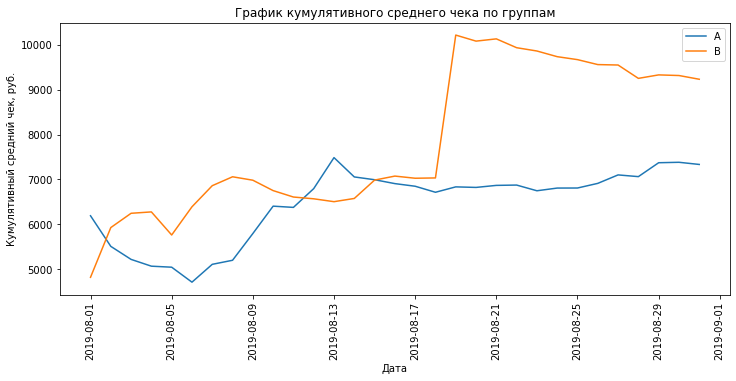

In [14]:
# графики среднего чека по группам 
plt.figure(figsize=(12, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation ='vertical')

plt.legend()
plt.ylabel('Кумулятивный средний чек, руб.')
plt.xlabel('Дата')
plt.title('График кумулятивного среднего чека по группам');

**Вывод:**

Средний чек для группы В 19 августа 2019 года скачкообразно возрастает, и это различие между чеками сохраняется до конца теста. Во второй половине теста в группу B попали аномально крупные заказы.

### График относительного изменения кумулятивного среднего чека группы B к группе A

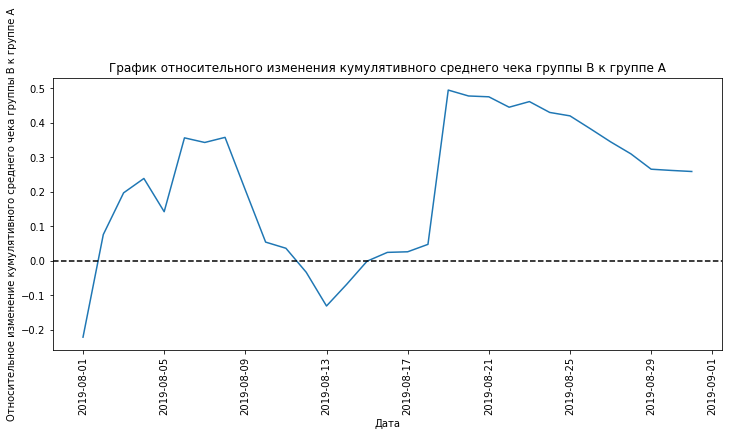

In [15]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(12, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation ='vertical')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.ylabel('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A');

**Вывод:**

В нескольких точках график различия между сегментами резко «скачет». Причины, вероятно, связаны с крупными заказами и выбросами.

### График кумулятивной конверсии по группам

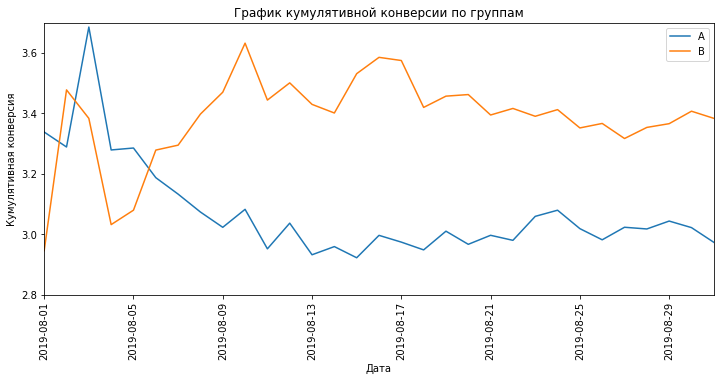

In [16]:
# посчитаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors'] * 100

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(12, 5))
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xticks(rotation ='vertical')
plt.legend()

plt.axis(["2019-08-01", '2019-08-31', 2.8, 3.7]);

plt.ylabel('Кумулятивная конверсия')
plt.xlabel('Дата')
plt.title('График кумулятивной конверсии по группам');

**Вывод:**

В начале теста конверсии обеих групп подскачили вверх, а затем так же резко упали вниз. Потом конверсия группы В устремилась вверх, а конверсия группы А, наоборот, просела. Далее общая картина не менялась, до конца теста конверсии обеих групп зафиксировались и колебались около одних и тех же значений. 

### График относительного изменения кумулятивной конверсии группы B к группе A

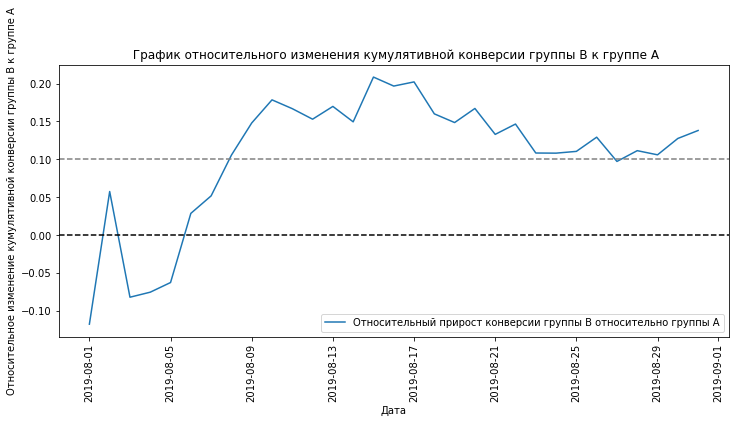

In [17]:
# построим график относительного различия кумулятивных конверсий:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.xticks(rotation ='vertical')

plt.legend()
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axhline(y=0.0, color='black', linestyle='--')

plt.ylabel('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.title(' График относительного изменения кумулятивной конверсии группы B к группе A');

**Вывод:**

В начале теста конверсии групп прыгали вверх-вниз. Затем конверсия группы В устремилась вверх и далее до конца теста значительно опережала конверсию группы А, даже несмотря на некоторое снижение во второй половине эксперимента. 

### Точечный график количества заказов по пользователям

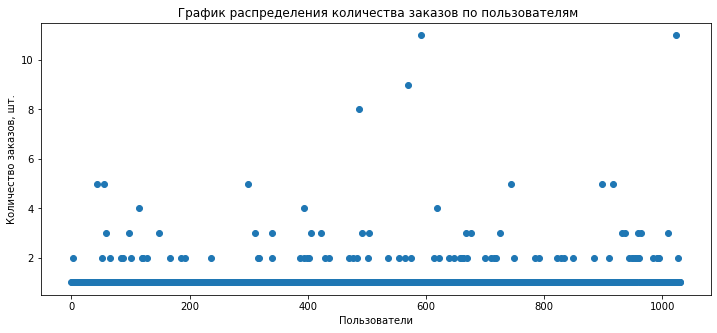

In [18]:
# посчитаем количество заказов по пользователям и запишем в ordersByUsers
ordersByUsers = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
ordersByUsers.columns = ['visitor_id', 'orders']

# построим точечную диаграмму количества заказов на одного пользователя
plt.figure(figsize=(12, 5))
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])

plt.ylabel('Количество заказов, шт.')
plt.xlabel('Пользователи')
plt.title(' График распределения количества заказов по пользователям');

**Вывод:**

Имеется много пользователей с 2-3 заказами, однако их точная доля не ясна, потому непонятно, считать их аномалиями или нет.

### 95-й и 99-й перцентили количества заказов на пользователя

In [19]:
# определим 95 и 99 перцентили количества заказов на пользователя
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


**Вывод:**

Не более 5% пользователей оформляли больше чем 2 заказа. И 1% пользователей заказывали более 4 раз.
Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

### Точечный график стоимостей заказов

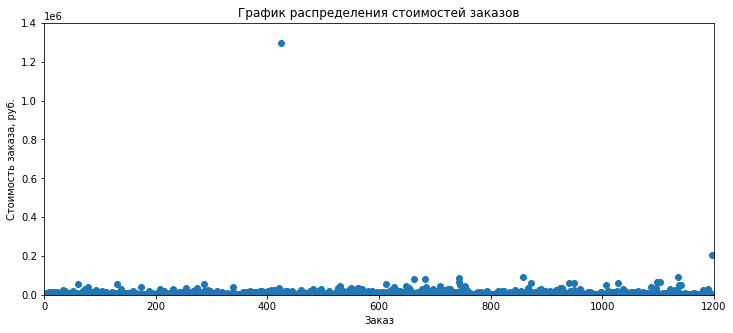

In [20]:
# построим точечный график распределения стоимостей заказов
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(12, 5))

plt.scatter(x_values, orders['revenue'])
plt.axis([0, 1200, 0, 1400000])

plt.xlabel('Заказ')
plt.ylabel(r'Стоимость заказа, руб.')
plt.title(r'График распределения стоимостей заказов');

Очевидно, что заказы на 1.2 млн руб и 200 тыс. руб. являются явными выбросами. 
Не будем обращать на них внимание и откорректируем лимиты по осям графика для его комфортного отображения:

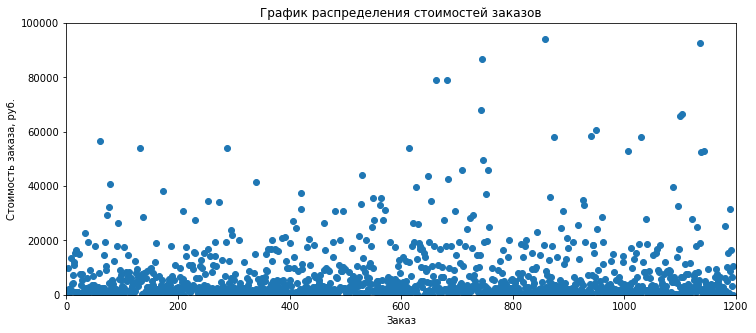

In [21]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(12, 5))

plt.scatter(x_values, orders['revenue'])
plt.axis([0, 1200, 0, 100000])

plt.xlabel('Заказ')
plt.ylabel(r'Стоимость заказа, руб.')
plt.title(r'График распределения стоимостей заказов');

**Вывод:**

По графику можно выбрать границу аномальных заказов между 25000 и 60000 рублей. 

### 95-й и 99-й перцентили стоимости заказов

In [22]:
# Определим 95 и 99 перцентили стоимости заказов
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


**Вывод:**

Не более 5% пользователей оформляли заказы дороже 28000 руб. И 1% пользователей заказывали более чем на 58233 руб.
Разумно выбрать 28000 руб. за верхнюю границу стоимости заказа, и отсеять аномальных пользователей по ней.

### Cтатистическая значимость различий в конверсии между группами по «сырым» данным

Сформулируем гипотезы. 

* Нулевая: различий в конверсии между группами нет. 
* Альтернативная: различия в конверсии между группами есть.

Критический уровень статистической значимости: alpha = 0.05

Рассчитаем статистическую значимость различий в конверсии между группами:

In [23]:
# Подготовим данные для расчета статистической значимости различий в конверсии между группами:
# количество пользователей по датам в группе A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# кумулятивное количество пользователей по датам в группе A
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# количество пользователей по датам в группе В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# кумулятивное количество пользователей по датам в группе В
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# количество заказов по датам в группе A
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitor_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# кумулятивное количество заказов по датам в группе A
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# количество заказов по датам в группе В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# кумулятивное количество заказов по датам в группе В
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# объединенный датасет с метриками
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

# таблица с пользователями, которые заказывали хотя бы 1 раз, и количетсвом совершённых ими заказов для группы А
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

# таблица с пользователями, которые заказывали хотя бы 1 раз, и количесnвом совершённых ими заказов для группы В
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

# таблица с пользователями и количеством совершенных ими заказом для группы А
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# таблица с пользователями и количеством совершенных ими заказом для группы В
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
p_value = stats.mannwhitneyu(sampleA, sampleB)[1]

alpha = 0.05 # критический уровень статистической значимости
print("p-value: {0:.3f}".format(p_value))
print("Относительное различие в конверсии между группами: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: в конверсии между группами есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: нет оснований считать конверсии между группами разными'
    )

p-value: 0.017
Относительное различие в конверсии между группами: 0.138
Отвергаем нулевую гипотезу: в конверсии между группами есть значимая разница


**Вывод:**

p-value = 0.017. Значит нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы. 

* Нулевая: различий в среднем чеке заказа между группами нет. 
* Альтернативная: различия в среднем чеке заказа между группами есть.

alpha = 0.05

In [24]:
# рассчитаем статистическую значимость различий в среднем чеке заказа
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print('p-value: {0:.3f}'.format(p_value))

# относительные различия в среднем чеке между группами
print('Относительные различия в среднем чеке между группами: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: в среднем чеке заказа между группами есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: нет оснований считать, что средние чеки заказа значительно различаются между группами'
    )

p-value: 0.729
Относительные различия в среднем чеке между группами: 0.259
Не получилось отвергнуть нулевую гипотезу: нет оснований считать, что средние чеки заказа значительно различаются между группами


**Вывод:**

p-value = 0.729. Значит причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.
Однако средний чек группы B значительно выше среднего чека группы A. Существенная относительная разница при отсутствии статистической значимости указывает на влияние выбросов на значение среднего чека.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Ранее были найдены 95-й и 99-й перцентили средних чеков, которые равны 28 000 и 58 233 рубля, соответственно. 

А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказам на пользователя.

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и 5% пользователей с дорогими заказами.

Найдем статистическую значимость различий в конверсии между группами по «очищенным» данным:

In [25]:
many_orders_limit = int(np.percentile(ordersByUsers['orders'], [95]))
expensive_revenue_limit = int(np.percentile(orders['revenue'], [95]))

# аномальные пользователи с большим количеством заказов
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > many_orders_limit]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > many_orders_limit]['visitor_id'],
    ],
    axis=0,
)

# аномальные пользователи с дорогими заказами
usersWithExpensiveOrders = orders[orders['revenue'] > expensive_revenue_limit]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

# подготовим выборки конверсии по группам теста
# таблица с пользователями и количеством совершенных ими заказом для группы А
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# таблица с пользователями и количеством совершенных ими заказом для группы В
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("Относительное различие в конверсии между группами: {0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: в конверсии между группами есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: нет оснований считать конверсии между группами разными'
    )

p-value: 0.013
Относительное различие в конверсии между группами: 0.173
Не получилось отвергнуть нулевую гипотезу: нет оснований считать конверсии между группами разными


**Вывод:**

По очищенным данным p-value уменьшилось до 0.013. После очистки данных от выбросов относительная разница в конверсии между группами увеличилась. 

Общий результат не изменился: нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. При имеющихся данных группа B показывает лучшие результаты по статистически значимым различием в конверсии между группами.

###  Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Определим, есть ли изменения с результатами по среднему чеку заказа между группами:

In [26]:
p_value = (stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
          )

print('p-value: {0:.3f}'.format(p_value))

# относительный прирост среднего чекa
print(
    "Относительный прирост среднего чекa группы В:{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
                - 1
    )
)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: в среднем чеке заказа между группами есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: нет оснований считать, что средние чеки заказа значительно различаются между группами'
    )


p-value: 0.738
Относительный прирост среднего чекa группы В:-0.020
Не получилось отвергнуть нулевую гипотезу: нет оснований считать, что средние чеки заказа значительно различаются между группами


**Вывод:**

Значение p-value незначительно увеличилось. После очистки данных от выбросов существенная относительная разница в среднем чеке между группами исчезла. 

Общий результат не изменился: причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.

### Решение по результатам теста 

По результатам исследования имеем следующие факты:
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым» данным, ни по данным после фильтрации аномалий. Существенная относительная разница при отсутствии статистической значимости указывает на влияние выбросов на значение среднего чека;
* Есть статистически значимое различие в конверсии между группами как по по «сырым» данным, так и по отфмльтрованным от аномалий данным;
* График различия конверсии между группами сообщает, что результаты группы B значительно лучше группы А: результаты группы В к концу теста зафиксировались около среднего значения и имеют тенденцию к росту;
* График различия среднего чека говорит о том, что результаты группы B по «сырым» данным показывали лучшую картину за счет аномалий;
* Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. При имеющихся данных сегмент B лучше сегмента A.

**Вывод:**

Тест показал наличие статистически значимого различия в конверсии между группами: при имеющихся данных результаты группы B лучше группы A. Поэтому принимаем решение, что тест нужно остановить.

## Общий вывод

Для того, чтобы подготовить предложения для увеличения выручки интернет-магазина, мы использовали входные данные со списком гипотез, а также статистикой по заказам и пользоватям по итогу проведенного A/B-теста.

Данные были предобработаны для проведения исследования. После этого были приоритизированы гипотезы, запущен A/B-тест и проанализированы его результаты.

По итогу исследования были получены следующие результаты:
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым» данным, ни по данным после фильтрации аномалий;
* Есть статистически значимое различие в конверсии между группами как по по «сырым» данным, так и по отфмльтрованным от аномалий данным;
* График различия конверсии между группами сообщает, что результаты группы B значительно лучше группы А: результаты группы В к концу теста зафиксировались около среднего значения и имеют тенденцию к росту;
* График различия среднего чека говорит о том, что результаты группы B по «сырым» данным показывали лучшую картину за счет аномалий;

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. При имеющихся данных сегмент B показывает лучшие результаты, по сравнению с сегментом A.

**Рекомендации для увеличения выручки:**

Исходя из обнаруженных фактов, тест следует остановить и признать успешным. 

При имеющихся данных сегмент B показывает лучшие результаты по статистически значимым различием в конверсии между группами.
Для увеличения выручки бизнеса нашего интернет-магазина будет рационально реализовать гипотезу №8 для группы В.